# CS 7641 Machine Learning - Programming Assignment 2

In [1]:
import numpy as np
import pandas as pd
import mlrose_hiive
import matplotlib.pyplot as plt
import seaborn as sn

# import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import mlrose
from mlrose_hiive import NNGSRunner, SARunner, GARunner, TSPGenerator, RHCRunner, MIMICRunner, GeomDecay, ExpDecay, ArithDecay

import sklearn

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, learning_curve, validation_curve, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import InstanceHardnessThreshold, CondensedNearestNeighbour

%matplotlib inline

import time

random_seed = 1
np.random.seed(random_seed)

# Define decay schedule
schedule = mlrose_hiive.ExpDecay()

SAVE_IMAGES=True



## 3 Randomized Optimization Problems

In [80]:
def create_ro_curve_all(x_range, rhc, sa, ga, mimic, title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, rhc, label='Randomized Hill Climbing')
    plt.plot(x_range, sa, label='Simulated Annealing')
    plt.plot(x_range, ga, label='Genetic Algorithms')
    plt.plot(x_range, mimic, label='MIMIC')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def create_ro_curve_one(x_range, scores, legend = '', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, scores, label=legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
    

def run_rhc(problem_name, problem, state, max_iter):
    start = time.time()
    fitness_scores = np.zeros(max_iter+1)
    times = np.zeros(max_iter+1)
    for iter in range(1, max_iter+1):
        iter_start = time.time()
        best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(problem,
                                                          max_attempts = 10, max_iters = iter,
                                                          init_state = state, random_state = random_seed, curve=True)
        fitness_scores[iter] = best_fitness
        iter_end = time.time()
        times[iter] = iter_end - iter_start
    end = time.time()
    print(f'Randomized Hill Climbing completed for {problem_name} in {end-start} s')
    times = np.cumsum(times)
    return fitness_scores, best_state, best_fitness, fitness_curve, times



def run_sa(problem_name, problem, state, schedule, max_iter):
    start = time.time()
    fitness_scores = np.zeros(max_iter+1)
    times = np.zeros(max_iter+1)
    for iter in range(1, max_iter+1):
        iter_start = time.time()
        best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(problem, schedule = schedule,
                                                          max_attempts = 10, max_iters = iter,
                                                          init_state = state, random_state = random_seed, curve=True)
        fitness_scores[iter] = best_fitness
        iter_end = time.time()
        times[iter] = iter_end - iter_start
    end = time.time()
    print(f'Simulated Annealing completed for {problem_name} in {end-start} s')
    times = np.cumsum(times)
    return fitness_scores, best_state, best_fitness, fitness_curve, times



def run_ga(problem_name, problem, population_size, max_iter, mutation_prob=0.1):
    start = time.time()
    fitness_scores = np.zeros(max_iter+1)
    times = np.zeros(max_iter+1)
    for iter in range(1, max_iter+1):
        iter_start = time.time()
        best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(problem, pop_size=population_size,
                                                        mutation_prob=mutation_prob, max_attempts = 10, max_iters = iter, 
                                                        random_state = random_seed, curve=True)
        fitness_scores[iter] = best_fitness
        iter_end = time.time()
        times[iter] = iter_end - iter_start
    end = time.time()
    print(f'Genetic Algorithms completed for {problem_name} in {end-start} s')
    times = np.cumsum(times)
    return fitness_scores, best_state, best_fitness, fitness_curve, times


def run_mimic(problem_name, problem, population_size, max_iter, keep_pct=0.2):
    start = time.time()
    fitness_scores = np.zeros(max_iter+1)
    times = np.zeros(max_iter+1)
    for iter in range(1, max_iter+1):
        iter_start = time.time()
        best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(problem, pop_size=population_size, keep_pct=keep_pct,
                                                      max_attempts = 10, max_iters = iter,
                                                      random_state = random_seed, curve=True)
        fitness_scores[iter] = best_fitness
        iter_end = time.time()
        times[iter] = iter_end - iter_start
        if iter%10 == 0:
            print(f'Iteration {iter} completed in {iter_end - iter_start} ')
    end = time.time()
    print(f'MIMIC completed for {problem_name} in {end-start} s')
    times = np.cumsum(times)
    return fitness_scores, best_state, best_fitness, fitness_curve, times





## Utility functions

# First column in both the dataset is ID column which serves no purpose in classifiation and does not tells us about the sample. 
# Therefore id column will be removed from data
def getData(id):
    if id == DATASET_1:
        data = pd.read_csv("healthcare-dataset-stroke-data.csv")
    elif id == DATASET_2:
        data = pd.read_csv("BankChurners.csv")
    data = data.iloc[:, 1:]
    return data


def print_metrics(classifier_type:str, y_test, y_pred):
    print(f'Metrics for classifier: {classifier_type}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix: \n {cm}')
    print(f'Accuracy score {accuracy_score(y_test, y_pred)}')
    print(f'Precision score {precision_score(y_test, y_pred)}')
    print(f'Recall score {recall_score(y_test, y_pred)}')
    print(f'ROC AUC score {roc_auc_score(y_test, y_pred)}')
    print(f'F1 score {f1_score(y_test, y_pred)}')
    
    
'''
data: dictionary
    x_values, train_scores, test_scores, train_legend, test_legend, title, xlabel, ylabel, figname
'''
def create_plot(data):
    x_values = data.get('x_values')
    train_scores = data.get('train_scores')
    test_scores = data.get('test_scores')
    test_legend = data.get('test_legend')
    train_legend = data.get('train_legend')
    figname = data.get('figname')
    
    plt.figure()
    plt.plot(x_values, train_scores, label=train_legend)
    plt.plot(x_values, test_scores, label=test_legend)
    plt.title(data.get('title'))
    plt.xlabel(data.get('xlabel'))
    plt.ylabel(data.get('ylabel'))
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def create_curve(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, np.mean(train_scores, axis=1), label=train_legend)
    plt.plot(x_range, np.mean(test_scores, axis=1), label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def get_correlations(data, dataset_id):
    if dataset_id == DATASET_1:
        return data.corr().stroke.sort_values()
    elif dataset_id == DATASET_2:
        return data.corr()['Attrition_Flag'].sort_values()

    
def do_column_one_hot_encoding(X, col_indices):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), col_indices)], remainder='passthrough')
    # remainder = passthrough means keep other columns on which encoding is not applied, else will get only enoded columns 
    X_encoded = ct.fit_transform(X)

    print(f'First row of X after imputation and encoding: {X_encoded[0]}')
    print(ct.get_feature_names_out())
    return X_encoded


# reference: https://www.udemy.com/course/machine-learning-with-imbalanced-data/

# reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-10-Instance-Hardness-Threshold.ipynb
rf = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)
iht = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy=.6,  # undersamples only the majority class
    random_state=random_seed,
    n_jobs=4, # have 4 processors in my laptop
    cv=3,  # cross validation fold
)

# Reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-02-Condensed-Nearest-Neighbours.ipynb
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

def do_resampling(X, y):
    if RESAMPLING_TECHNIQUE == USE_UNDERSAMPLING_IHT:
        X_resampled, y_resampled = iht.fit_resample(X, y)
    elif RESAMPLING_TECHNIQUE == USE_UNDERSAMPLING_CNN:
        X_resampled, y_resampled = cnn.fit_resample(X, y)
    elif RESAMPLING_TECHNIQUE == USE_OVERSAMPLING_SMOTE:
        X_resampled, y_resampled = smnc.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    print(f'After resampling with {RESAMPLING_TECHNIQUE}: Shape of X: {X_resampled.shape}, Shape of y: {y_resampled.shape}')

    unique, counts = np.unique(y_resampled, return_counts=True)
    print(f'After resampling: value counts: {unique} : {counts}')

    print(X_resampled[0])
    
    return X_resampled, y_resampled

def create_time_plot(title, xlabel, ylabel, knn_times, dt_times, ada_times, svm_times, nn_times, figname=''):
    x_range = np.arange(0.1, 1.0, .1)
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_range, np.sum(nn_times, axis=1), color="orange", label="Neural Networks")
    plt.plot(x_range, np.sum(svm_times, axis=1), color="green", label="SVM")
    plt.plot(x_range, np.sum(knn_times, axis=1), color="red", label="KNN")
    plt.plot(x_range, np.sum(dt_times, axis=1), color="blue", label="Decision Tree")
    plt.plot(x_range, np.sum(ada_times, axis=1), color="lime", label="Adaboost")
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def create_log_curve(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', 
                     title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.semilogx(x_range, np.mean(train_scores, axis=1), label=train_legend)
    plt.semilogx(x_range, np.mean(test_scores, axis=1), label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def create_loss_curve(scores=None, legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.title(title)
    plt.plot(scores, color="blue", label=legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def get_mean_score(test_scores):
    return np.mean(np.sum(test_scores, axis=1), axis=0)*fold_size


def do_feature_scaling(X_train, X_test, columns_to_scale):
    sc = StandardScaler()
    X_train[:, columns_to_scale] = sc.fit_transform(X_train[:, columns_to_scale])
    X_test[:, columns_to_scale] = sc.transform(X_test[:, columns_to_scale])

    X_train  = X_train.copy()
    X_test = X_test.copy()
    
    return X_train, X_test

### Flip Flop problem

In [91]:
## Problem definition
max_iter = 300
x_range = range(0, max_iter+1)

fitness_flipflop = mlrose_hiive.FlipFlop()

# Reference: https://stackoverflow.com/a/26873621 (Python Random Array of 0s and 1s)
n = 50
m = 50
state_flipflop = np.hstack((np.ones(n), np.zeros(m)))
np.random.shuffle(state_flipflop)

problem_flipflop = mlrose_hiive.DiscreteOpt(length = state_flipflop.shape[0], fitness_fn = fitness_flipflop, maximize = True)

problem_name = 'Flip Flop'

Randomized Hill Climbing completed for Flip Flop in 0.5399885177612305 s


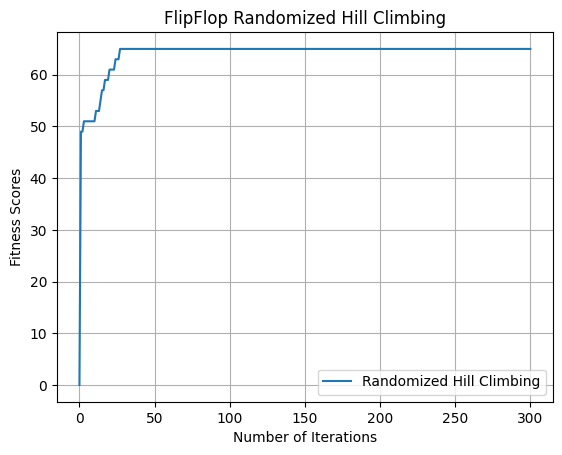

In [32]:
# RHC FlipFlop
fitness_scores_rhc, best_state_rhc, best_fitness_rhc, fitness_curve_rhc, times_rhc = run_rhc(problem_name, problem_flipflop, 
                                                                             state_flipflop, max_iter)

create_ro_curve_one(x_range, fitness_scores_rhc, legend = 'Randomized Hill Climbing', title='FlipFlop Randomized Hill Climbing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_rhc.png')

Simulated Annealing completed for Flip Flop in 2.7490010261535645 s


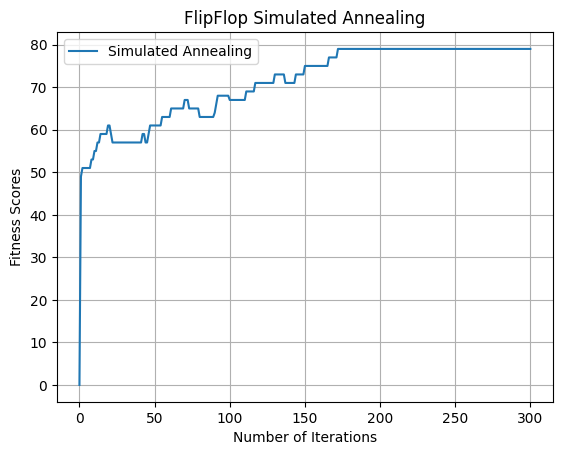

In [33]:
## SA FlipFlop
fitness_scores_sa, best_state_sa, best_fitness_sa, fitness_curve_sa, times_sa = run_sa(
                                                problem_name, problem_flipflop, state_flipflop, schedule, max_iter)
create_ro_curve_one(x_range, fitness_scores_sa, legend = 'Simulated Annealing', title='FlipFlop Simulated Annealing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_sa.png')

Genetic Algorithms completed for Flip Flop in 31.210266828536987 s


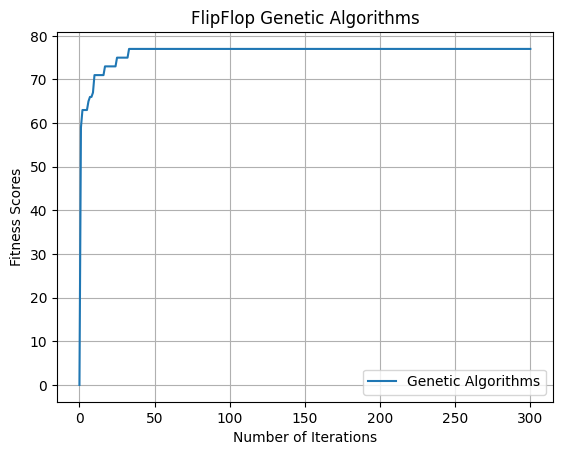

In [34]:
## GA FlipFlop
population_size_ga = state_flipflop.shape[0]
population_size_ga = 30
fitness_scores_ga, best_state_ga, best_fitness_ga, fitness_curve_ga, times_ga = run_ga(problem_name, 
                                                                             problem_flipflop, population_size_ga, 
                                                                             max_iter, mutation_prob=0.5)

create_ro_curve_one(x_range, fitness_scores_ga, legend = 'Genetic Algorithms', title='FlipFlop Genetic Algorithms', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_ga.png')

In [96]:
ff_population_size_mimic = 100
ff_fitness_scores_mimic, ff_best_state_mimic, ff_best_fitness_mimic, ff_fitness_curve_mimic, ff_times_mimic = run_mimic(
    'Flip Flop', problem_flipflop, ff_population_size_mimic, 30)



Iteration 10 completed in 34.948486328125 
Iteration 20 completed in 66.50627183914185 
Iteration 30 completed in 74.92023372650146 
MIMIC completed for Flip Flop in 1410.5538320541382 s


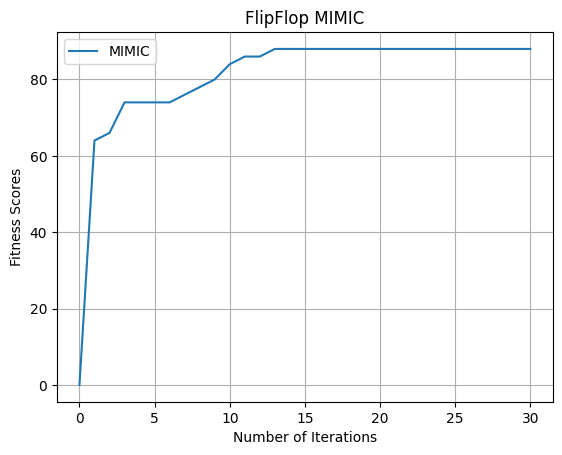

In [98]:
create_ro_curve_one(range(0, 31), ff_fitness_scores_mimic, legend = 'MIMIC', title='FlipFlop MIMIC', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_mimic.png')

In [ ]:
create_ro_curve_all(range(0, max_iter+1), times_rhc, times_sa, times_ga, times_mimic,
             title='Wall Clock Time - Flip Flop', x_label='Number of Iterations', 
             y_label='Time Taken', figname='timeplot_flipflop.png')

## Four Peaks

In [66]:
state.shape[0]

100

In [68]:
## Problem definition
max_iter = 300
x_range = range(0, max_iter+1)

fitness_fourpeaks = mlrose_hiive.FourPeaks()

# Reference: https://stackoverflow.com/a/26873621 (Python Random Array of 0s and 1s)
state = state_flipflop

problem_fourpeaks = mlrose_hiive.DiscreteOpt(length = state.shape[0], fitness_fn = fitness_fourpeaks, maximize = True)

problem_name = 'Four Peaks'

Randomized Hill Climbing completed for Four Peaks in 0.05900216102600098 s


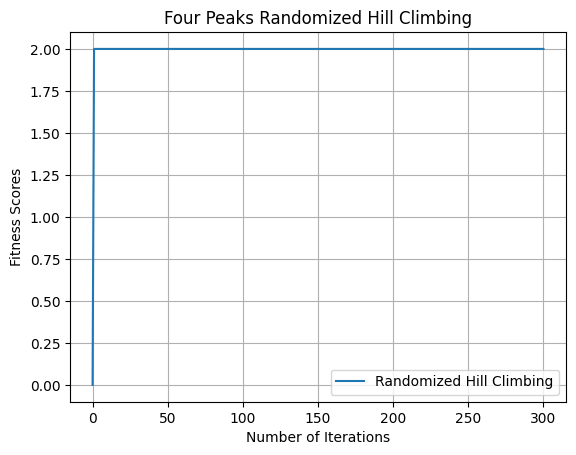

In [69]:
# RHC Four Peaks

fp_fitness_scores_rhc, fp_best_state_rhc, fp_best_fitness_rhc, fp_fitness_curve_rhc, fp_times_rhc = run_rhc(problem_name, problem_fourpeaks, 
                                                                             None, max_iter)

create_ro_curve_one(x_range, fp_fitness_scores_rhc, legend = 'Randomized Hill Climbing', title='Four Peaks Randomized Hill Climbing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='fp_rhc.png')

Simulated Annealing completed for Four Peaks in 0.9650228023529053 s


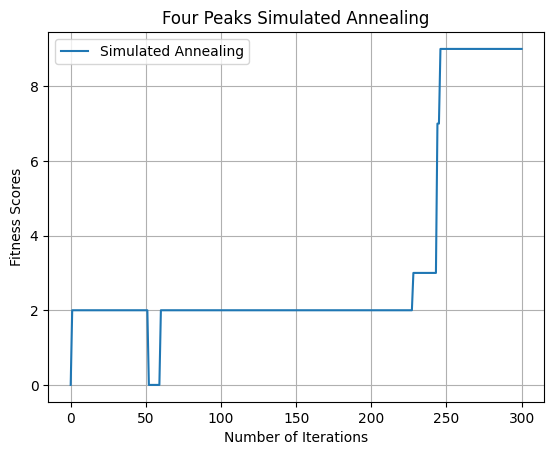

In [74]:
fp_schedule = ExpDecay()

fp_fitness_scores_sa, fp_best_state_sa, fp_best_fitness_sa, fp_fitness_curve_sa, fp_times_sa = run_sa(
                                                problem_name, problem_fourpeaks, None, fp_schedule, max_iter)
create_ro_curve_one(x_range, fp_fitness_scores_sa, legend = 'Simulated Annealing', title='Four Peaks Simulated Annealing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='fp_sa.png')

Genetic Algorithms completed for Four Peaks in 1.931999921798706 s


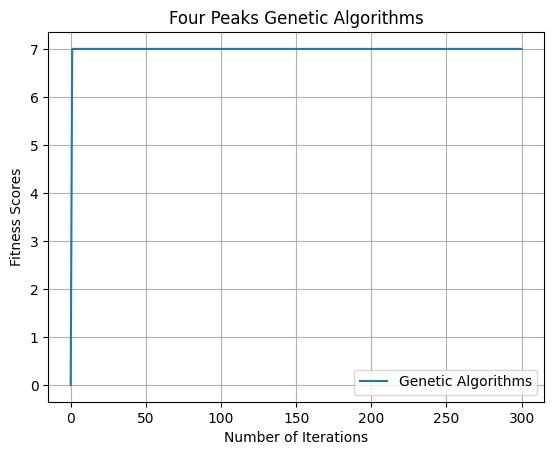

In [86]:
fp_fitness_scores_ga, fp_best_state_ga, fp_best_fitness_ga, fp_fitness_curve_ga, fp_times_ga = run_ga(
    problem_name, problem_fourpeaks, 10, max_iter, mutation_prob=0.5)
create_ro_curve_one(x_range, fp_fitness_scores_ga, legend = 'Genetic Algorithms', title='Four Peaks Genetic Algorithms', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='fp_ga.png')

Iteration 10 completed in 30.033878326416016 
Iteration 20 completed in 34.67178750038147 
Iteration 30 completed in 33.17543029785156 
Iteration 40 completed in 33.222212076187134 
Iteration 50 completed in 34.64433932304382 
MIMIC completed for Four Peaks in 1523.7662234306335 s


ValueError: x and y must have same first dimension, but have shapes (301,) and (51,)

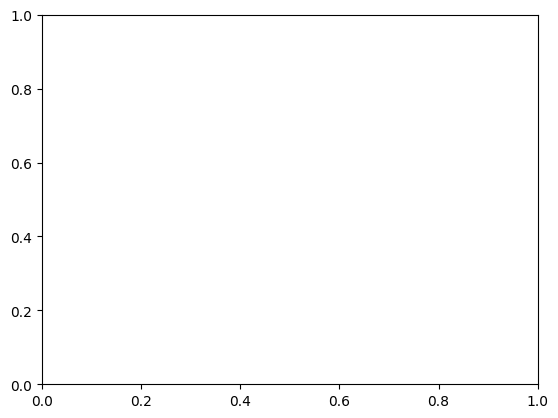

In [82]:
population_size_mimic = 20
fp_fitness_scores_mimic, fp_best_state_mimic, fp_best_fitness_mimic, fp_fitness_curve_mimic, fp_times_mimic = run_mimic(
    problem_name, problem_fourpeaks, population_size_mimic, 50)



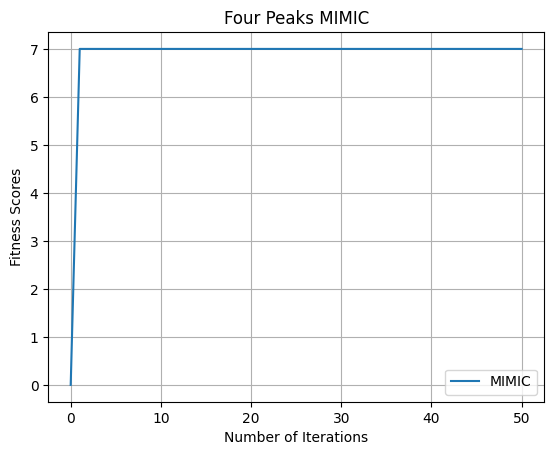

In [83]:
create_ro_curve_one(range(0, 51), fp_fitness_scores_mimic, legend = 'MIMIC', title='Four Peaks MIMIC', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='fp_mimic.png')

### Travelling Salesman Problem

In [41]:
problem_tsp = TSPGenerator.generate(seed=random_seed, number_of_cities=20)
problem_name = 'Travelling Salesman'
tsp_coords = problem_tsp.coords
tsp_distances = problem_tsp.distances

tsp_fitness_coord = mlrose_hiive.TravellingSales(coords = tsp_coords)
tsp_fitness_dist = mlrose_hiive.TravellingSales(distances = tsp_distances)


Randomized Hill Climbing completed for Travelling Salesman in 10.405036926269531 s


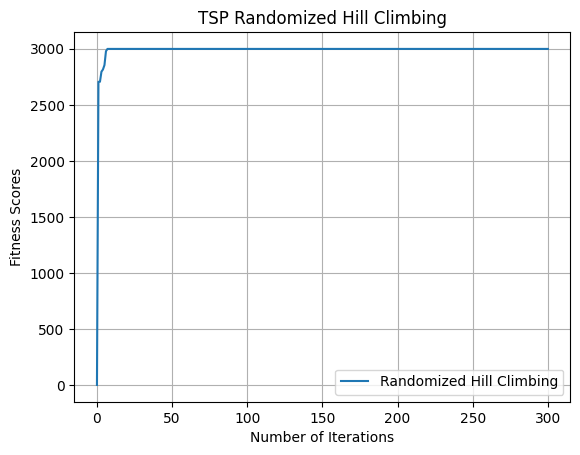

In [63]:
problem_tsp2 = mlrose_hiive.TSPOpt(length = len(tsp_coords), fitness_fn = tsp_fitness_dist, maximize=True)

tsp_fitness_scores_rhc2, tsp_best_state_rhc2, tsp_best_fitness_rhc2, tsp_fitness_curve_rhc2, tsp_times_rhc2 = run_rhc(problem_name, problem_tsp2, 
                                                                             None, max_iter)

create_ro_curve_one(x_range, tsp_fitness_scores_rhc2, legend = 'Randomized Hill Climbing', title='TSP Randomized Hill Climbing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_rhc2.png')

Simulated Annealing completed for Four Peaks in 36.07753872871399 s


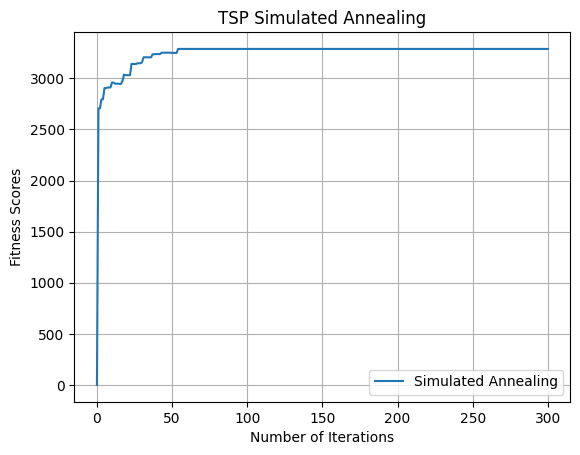

In [73]:
tsp_schedule2 = ArithDecay(10)

tsp_fitness_scores_sa2, tsp_best_state_sa2, tsp_best_fitness_sa2, tsp_fitness_curve_sa2, tsp_times_sa2 = run_sa(
                                                problem_name, problem_tsp2, None, tsp_schedule2, max_iter)
create_ro_curve_one(x_range, tsp_fitness_scores_sa2, legend = 'Simulated Annealing', title='TSP Simulated Annealing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_sa2.png')

Genetic Algorithms completed for Travelling Salesman in 341.6887638568878 s


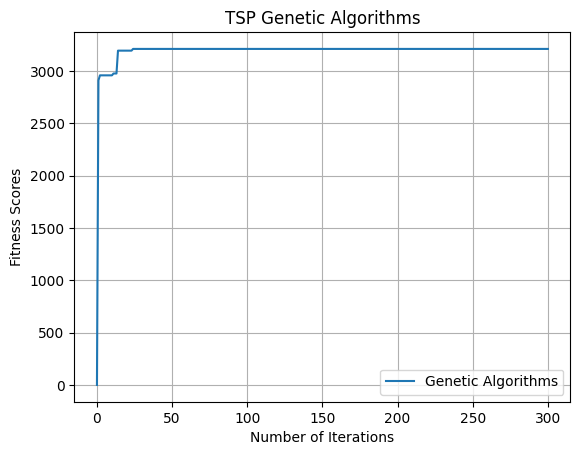

In [64]:
tsp_fitness_scores_ga2, tsp_best_state_ga2, tsp_best_fitness_ga2, tsp_fitness_curve_ga2, tsp_times_ga2 = run_ga(
    problem_name, problem_tsp2, 20, max_iter, mutation_prob=0.1)
create_ro_curve_one(x_range, tsp_fitness_scores_ga2, legend = 'Genetic Algorithms', title='TSP Genetic Algorithms', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_ga2.png')

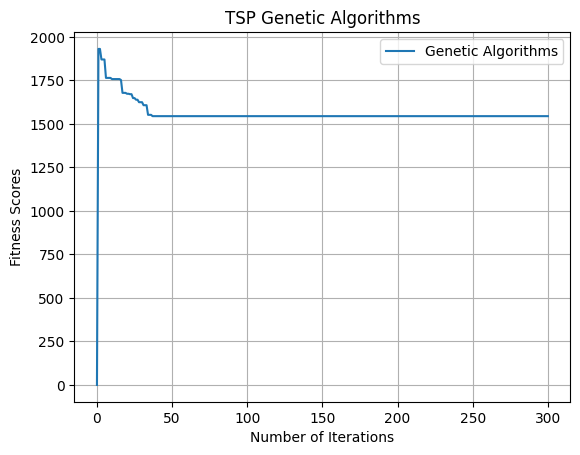

In [45]:
create_ro_curve_one(x_range, tsp_fitness_scores_ga, legend = 'Genetic Algorithms', title='TSP Genetic Algorithms', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_ga.png')

In [ ]:
tsp_population_size_mimic = 20
tsp_fitness_scores_mimic, tsp_best_state_mimic, tsp_best_fitness_mimic, tsp_fitness_curve_mimic, tsp_times_mimic = run_mimic(
    'TSP', problem_tsp, tsp_population_size_mimic, 50)

create_ro_curve_one(x_range, ff_fitness_scores_mimic, legend = 'MIMIC', title='FlipFlop MIMIC', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_mimic.png')

Randomized Hill Climbing completed for Travelling Salesman in 1.4800364971160889 s


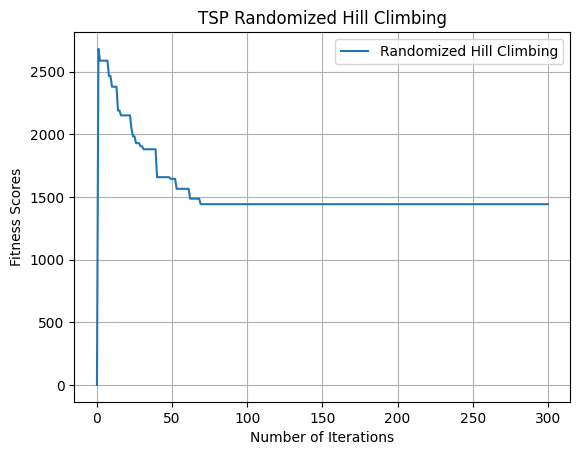

In [47]:
tsp_fitness_scores_rhc, tsp_best_state_rhc, tsp_best_fitness_rhc, tsp_fitness_curve_rhc, tsp_times_rhc = run_rhc(problem_name, problem_tsp, 
                                                                             None, max_iter)

create_ro_curve_one(x_range, tsp_fitness_scores_rhc, legend = 'Randomized Hill Climbing', title='TSP Randomized Hill Climbing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_rhc.png')

Simulated Annealing completed for Travelling Salesman in 1.8479955196380615 s


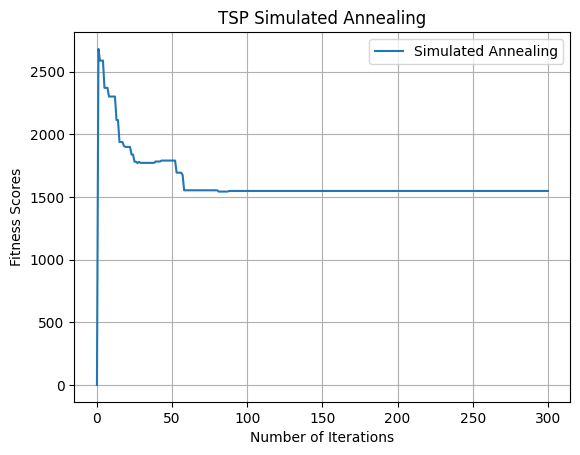

In [62]:
tsp_schedule = ArithDecay(10)

tsp_fitness_scores_sa, tsp_best_state_sa, tsp_best_fitness_sa, tsp_fitness_curve_sa, tsp_times_sa = run_sa(
                                                problem_name, problem_tsp, None, tsp_schedule, max_iter)
create_ro_curve_one(x_range, tsp_fitness_scores_sa, legend = 'Simulated Annealing', title='TSP Simulated Annealing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='tsp_sa.png')

In [ ]:
tsp_fitness_scores_rhc, tsp_best_state_rhc, tsp_best_fitness_rhc, tsp_fitness_curve_rhc, times_rhc = run_rhc(problem_name, problem_tsp, 
                                                                             state_flipflop, max_iter)

create_ro_curve_one(x_range, fitness_scores_rhc, legend = 'Randomized Hill Climbing', title='FlipFlop Randomized Hill Climbing', 
                    x_label='Number of Iterations', y_label='Fitness Scores', figname='flipflop_rhc.png')

In [ ]:
tsp_population_size_mimic = 20
tsp_fitness_scores_mimic, tsp_best_state_mimic, tsp_best_fitness_mimic, tsp_fitness_curve_mimic, tsp_times_mimic = run_mimic(
    'TSP', problem_tsp, tsp_population_size_mimic, 50)

create_ro_curve_one(x_range, tsp_fitness_scores_mimic, legend = 'MIMIC', title='TSP MIMIC', 
                    x_label='NUmber of Iterations', y_label='Fitness Scores', figname='tsp_mimic.png')

## Neural Network Optimization

### Dataset 2 Credit Card customers (Predict Churning customers)

In [3]:
# Common constants
USE_UNDERSAMPLING_IHT = 'USE_UNDERSAMPLING_IHT'
USE_UNDERSAMPLING_CNN = 'USE_UNDERSAMPLING_CNN'
USE_OVERSAMPLING_SMOTE = 'USE_OVERSAMPLING_SMOTE'

DATASET_1 = 'DATASET_1'
DATASET_2 = 'DATASET_2'

DATASET_ID = DATASET_1
RESAMPLING_TECHNIQUE = USE_UNDERSAMPLING_IHT

data1 = getData(DATASET_ID)

print(f'Shape of data1: {data1.shape}')

data1.head()

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data1['bmi'] = imputer.fit_transform(data1[['bmi']])
data1


X1 = data1.iloc[:, :-1].values
y1 = data1.iloc[:, -1].values

print(f'Shape of X1: {X1.shape}')
print(f'Shape of y1: {y1.shape}')

print(data1.columns)
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
# skipping OneHotEncoding of binary features based on following explanation: https://stackoverflow.com/a/64377627
col_indices1 = [data1.columns.get_loc(col) for col in cols_to_encode]
print(col_indices1)

X1 = do_column_one_hot_encoding(X1, col_indices1)


X_resampled1, y_resampled1 = do_resampling(X1, y1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled1, y_resampled1, test_size = 0.2, random_state = random_seed)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)



# manually scan and check which columns after OneHotEncoding have numeric values and scale them
columns_to_scale1 = [16, 19, 20]
X_train1, X_test1 = do_feature_scaling(X_train1, X_test1, columns_to_scale1)

Shape of data1: (5110, 11)
Shape of X1: (5110, 10)
Shape of y1: (5110,)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
[0, 4, 5, 6, 9]
First row of X after imputation and encoding: [0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 67.0 0 1
 228.69 36.6]
['encoder__x0_Female' 'encoder__x0_Male' 'encoder__x0_Other'
 'encoder__x4_No' 'encoder__x4_Yes' 'encoder__x5_Govt_job'
 'encoder__x5_Never_worked' 'encoder__x5_Private'
 'encoder__x5_Self-employed' 'encoder__x5_children' 'encoder__x6_Rural'
 'encoder__x6_Urban' 'encoder__x9_Unknown' 'encoder__x9_formerly smoked'
 'encoder__x9_never smoked' 'encoder__x9_smokes' 'remainder__x1'
 'remainder__x2' 'remainder__x3' 'remainder__x7' 'remainder__x8']
After resampling with USE_UNDERSAMPLING_IHT: Shape of X: (897, 21), Shape of y: (897,)
After resampling: value counts: [0 1] : [648 249

In [4]:
def mlrose_nn(algorithm_name, X_train, y_train, X_test, y_test):
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes = [2], activation = 'relu', \
                                 algorithm = algorithm_name, max_iters = 1000, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = random_seed)

    nn_model1.fit(X_train, y_train)
    y_train_pred = nn_model1.predict(X_train)
    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model1.predict(X_test)
    
    return y_train_pred, y_test_pred

def nn_learning_curve(algorithm_name, X_train, y_train, X_test, y_test, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    y_train_pred, y_test_pred = mlrose_nn(algorithm_name, X_train, y_train, X_test, y_test)
    
    nn_train_scores = f1_score(y_train, y_train_pred)
    nn_test_scores = f1_score(y_test, y_test_pred)
    
    #create_curve(x_range=train_sizes, train_scores=nn_train_scores, test_scores=nn_test_scores, train_legend='Training score', test_legend='Test score', 
    #             title='Neural Networks Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return nn_train_scores, nn_test_scores

In [ ]:
nn_train_scores2, nn_test_scores2 = nn_learning_curve('random_hill_climb', X_train2, y_train2, X_test2, y_test2)

In [ ]:
train_sizes = np.arange(0.1, 1.0, .1)
y_train_pred, y_test_pred = mlrose_nn('random_hill_climb', X_train2, y_train2, X_test2, y_test2)
    
nn_train_scores = f1_score(y_train2, y_train_pred)
nn_test_scores = f1_score(y_test2, y_test_pred)

In [17]:
## Reference: https://github.com/hiive/mlrose/blob/master/problem_examples.ipynb

grid_search_parameters_rhc = {
    'max_iters': [500, 1000, 2000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1, 1],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'restarts': [1]                             # rhc params
}

nnr_rhc = NNGSRunner(x_train=X_train1, y_train=y_train1, x_test=X_test1, y_test=y_test1, experiment_name='nn_test_rhc',
    algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb, grid_search_parameters=grid_search_parameters_rhc,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000], hidden_layer_sizes=[[X_train1.shape[1]]], 
    bias=True, early_stopping=True, clip_max=5, max_attempts=500, n_jobs=5, seed=random_seed, output_directory=None
)

run_stats_df_rhc, curves_df_rhc, cv_results_df_rhc, grid_search_cv_rhc = nnr_rhc.run()

grid_search_cv_rhc.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


NNClassifier(activation=<function relu at 0x000001D6B219DC60>,
             algorithm=<function random_hill_climb at 0x000001D6B219D5A0>,
             clip_max=5, early_stopping=True, hidden_layer_sizes=[21],
             learning_rate=0.001, max_attempts=500, max_iters=2000, restarts=1,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x000001D6D10733A0>,
             seed=1)

In [12]:
grid_search_parameters_sa = {
    'max_iters': [500, 1000, 2000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1, 1],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'schedule': [GeomDecay(init_temp=1, decay=0.99), GeomDecay(init_temp=0.1, decay=0.99), GeomDecay(init_temp=10, decay=0.99)] 
}

nnr_sa = NNGSRunner(x_train=X_train1, y_train=y_train1, x_test=X_test1, y_test=y_test1, experiment_name='nn_test_sa',
    algorithm=mlrose_hiive.algorithms.simulated_annealing, grid_search_parameters=grid_search_parameters_sa,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000], hidden_layer_sizes=[[X_train1.shape[1]]], 
    bias=True, early_stopping=True, clip_max=5, max_attempts=500, n_jobs=5, seed=random_seed, output_directory=None, generate_curves=True)

run_stats_df_sa, curves_df_sa, cv_results_df_sa, grid_search_cv_sa = nnr_sa.run()

grid_search_cv_sa.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


NNClassifier(activation=<function relu at 0x000002AEE2841C60>,
             algorithm=<function simulated_annealing at 0x000002AEE2840280>,
             clip_max=5, early_stopping=True, hidden_layer_sizes=[21],
             learning_rate=0.001, max_attempts=500, max_iters=2000,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x000002AE8650C4C0>,
             schedule=GeomDecay(init_temp=10, decay=0.99, min_temp=0.001),
             seed=1)

In [4]:
grid_search_parameters_ga = {
    'max_iters': [500, 1000, 2000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1, 1],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'pop_size': [20, 30, 40],
    'mutation_prob': [0.1, 0.2, 0.3, 0.4, 0.5]
}

nnr_ga = NNGSRunner(x_train=X_train1, y_train=y_train1, x_test=X_test1, y_test=y_test1, experiment_name="nn_test_ga",
                 algorithm=mlrose_hiive.algorithms.genetic_alg , grid_search_parameters=grid_search_parameters_ga, 
                 iteration_list=[1, 10, 50, 100, 250, 500, 1000],
                 hidden_layer_sizes=[[X_train1.shape[1]]], 
                 bias=True, early_stopping=True, clip_max=5, max_attempts=10, generate_curves=True, seed=random_seed, output_directory=None)

run_stats_df_ga, curves_df_ga, cv_results_df_ga, grid_search_cv_ga = nnr_ga.run()

grid_search_cv_ga.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


NNClassifier(activation=<function relu at 0x000001D6B219DC60>,
             algorithm=<function genetic_alg at 0x000001D6B219C1F0>, clip_max=5,
             early_stopping=True, hidden_layer_sizes=[21], learning_rate=0.001,
             max_iters=500, mutation_prob=0.1, pop_size=40,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x000001D6D005EB30>,
             seed=1)

In [ ]:
mlrose_hiive.algorithms.genetic_alg
mlrose_hiive.algorithms.random_hill_climb
mlrose_hiive.algorithms.simulated_annealing

In [20]:
input_features = X_train1.shape[1]

nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[input_features],
                                activation='relu',
                                algorithm='random_hill_climb',
                                max_iters=2000,
                                max_attempts=500,
                                bias=True,
                                is_classifier=True,
                                early_stopping=True,
                                clip_max=5,
                                curve=True,
                                learning_rate=0.001,
                                random_state=random_seed)

nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[input_features],
                                activation='relu',
                                algorithm='simulated_annealing',
                                max_iters=2000,
                                max_attempts=500,
                                bias=True,
                                is_classifier=True,
                                early_stopping=True,
                                clip_max=5.0,
                                curve=True,
                                learning_rate=0.001,
                                schedule=GeomDecay(init_temp=10, decay=0.99, min_temp=0.001),
                                random_state=random_seed)

nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[input_features],
                                activation='relu',
                                algorithm='genetic_alg',
                                max_iters=500,
                                max_attempts=100,
                                bias=True,
                                is_classifier=True,
                                learning_rate=0.001,
                                early_stopping=True,
                                clip_max=5.0,
                                curve=True,
                                pop_size=40,
                                mutation_prob=0.1,
                                random_state=random_seed)

In [24]:
def nn_learning_curve(nn_model, X_train, y_train, X_test, y_test, title='Neural Networks Learning curve', figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times = learning_curve(nn_model, X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=nn_train_scores, test_scores=nn_test_scores, train_legend='Training score', test_legend='Test score', 
                 title=title, x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times

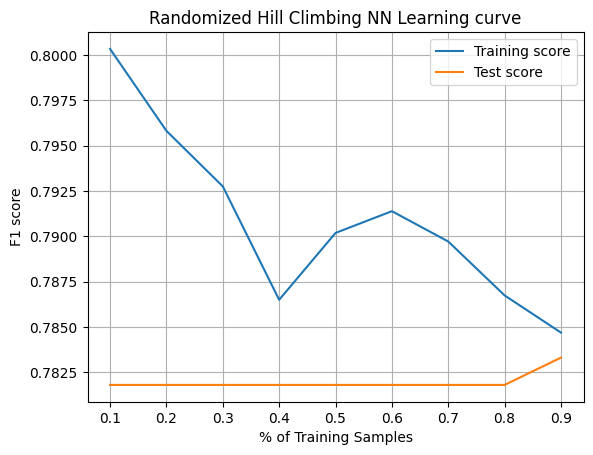

In [26]:
train_sizes_abs, nn_train_scores_rhc, nn_test_scores_rhc, nn_fit_times_rhc, nn_score_times_rhc = nn_learning_curve(nn_model_rhc,
    X_train1, y_train1, X_test1, y_test1, title='Randomized Hill Climbing NN Learning curve', figname='ds1_nn_learning_curve_rhc.png')

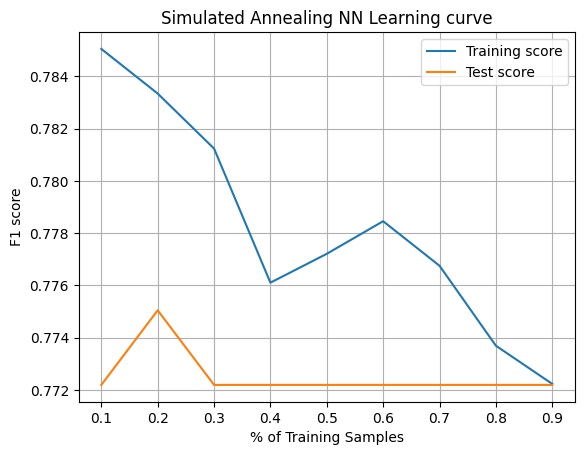

In [27]:
train_sizes_abs, nn_train_scores_sa, nn_test_scores_sa, nn_fit_times_sa, nn_score_times_sa = nn_learning_curve(nn_model_sa,
    X_train1, y_train1, X_test1, y_test1, title='Simulated Annealing NN Learning curve', figname='ds1_nn_learning_curve_sa.png')

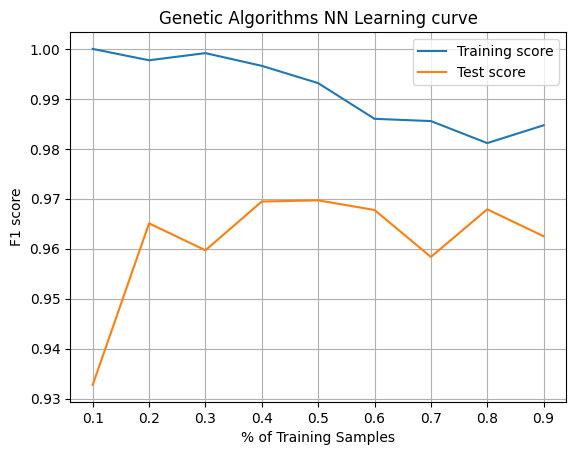

In [28]:
train_sizes_abs, nn_train_scores_ga, nn_test_scores_ga, nn_fit_times_ga, nn_score_times_ga = nn_learning_curve(nn_model_ga,
    X_train1, y_train1, X_test1, y_test1, title='Genetic Algorithms NN Learning curve', figname='ds1_nn_learning_curve_ga.png')